In [1]:
%load_ext autoreload
%autoreload 2

# Importación de librerías

In [3]:
from itertools import product
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    recall_score,
    f1_score,
    precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.fault_detection import detect_fault
from pathlib import Path

from src import paths

# Importar datos

In [ ]:
!cp -r /content/drive/MyDrive/Colab\ Notebooks/IPre\ sat/PixelModel/tcouso-3.0-DetectionResultsData/. /content

In [ ]:
!ls /content

drive  poly_predictions.pickle	sample_data  signal_simulations.pickle	y_vector_polygons.csv


In [ ]:
y_true_pixels = pd.read_csv("/content/y_vector_polygons.csv", index_col=["ID", "uniq_IDpix"])
y_true = y_true_pixels.groupby("ID").min()
y_true = y_true.iloc[:, 0]

In [5]:
signal_simulations_path = paths.data_processed_dir("signal_simulation", "signal_simulations.pickle")

with open(signal_simulations_path, "rb") as file:
  signal_simulations = pickle.load(file)

In [17]:
signal_simulations[0]["forecasts"][0]

array([[0.69377977],
       [0.68004574],
       [0.70437235],
       [0.68596083],
       [0.68513319],
       [0.70597137],
       [0.69876577],
       [0.7008208 ],
       [0.68992455],
       [0.69235837],
       [0.69087875],
       [0.70446005],
       [0.68841094],
       [0.70385859],
       [0.72161575],
       [0.70447113],
       [0.71205358],
       [0.69570043],
       [0.6999704 ],
       [0.68792083],
       [0.6867138 ],
       [0.67277505],
       [0.66907341],
       [0.66748141],
       [0.66446974],
       [0.69080374],
       [0.66648269],
       [0.66215159],
       [0.65479519],
       [0.63309312],
       [0.64181166],
       [0.63351672],
       [0.64749934],
       [0.65177579],
       [0.68394225],
       [0.69002051],
       [0.69611754],
       [0.68656962],
       [0.67665015],
       [0.68613181],
       [0.67522261],
       [0.67904032],
       [0.68250473],
       [0.70423836],
       [0.70587755],
       [0.71245455],
       [0.72597705],
       [0.715

In [ ]:
with open("/content/poly_predictions.pickle", "rb") as file:
  poly_predictions = pickle.load(file)

# Importar clasificación de territorio de cada píxel

In [ ]:
!cp -r /content/drive/MyDrive/Colab\ Notebooks/IPre\ sat/PixelModel/data/logging_forest_type.csv /content
!cp -r /content/drive/MyDrive/Colab\ Notebooks/IPre\ sat/PixelModel/data/fire_forest_type.csv /content
!cp -r /content/drive/MyDrive/Colab\ Notebooks/IPre\ sat/PixelModel/data/drought_forest_type.csv /content
!cp -r /content/drive/MyDrive/Colab\ Notebooks/IPre\ sat/PixelModel/data/stable_forest_type.csv /content

In [ ]:
logging_forest_type = pd.read_csv("logging_forest_type.csv", index_col=0)
fire_forest_type = pd.read_csv("fire_forest_type.csv", index_col=0)
drought_forest_type = pd.read_csv("drought_forest_type.csv", index_col=0)
stable_forest_type = pd.read_csv("stable_forest_type.csv", index_col=0)

In [ ]:
logging_forest_type["ChangeType"] = "logging"
fire_forest_type["ChangeType"] = "fire"
drought_forest_type["ChangeType"] = "drought"
stable_forest_type["ChangeType"] = "stable"

In [ ]:
all_forest_types = pd.concat([stable_forest_type, logging_forest_type, drought_forest_type, fire_forest_type], axis=0)

In [ ]:
all_forest_types = all_forest_types.loc[y_true.index]

In [ ]:
labeled_y_true = all_forest_types.join(y_true.rename("label"))

In [ ]:
labeled_y_true

,ORIGdesde,ChangeType,label
ID,,,
3,NATIVO,stable,0.0
5,NATIVO,stable,0.0
6,NATIVO,stable,0.0
7,NATIVO,stable,0.0
8,NATIVO,stable,0.0
...,...,...,...
421,EXOTICO,fire,1.0
422,EXOTICO,fire,1.0
423,EXOTICO,fire,1.0


# Desempeño según categoría

Se mide desempeño según tres tipos de atrubutos:

* Tipo de vegetación: NATIVO, EXOTICO, MIXTO


* Tipo de no-cambio: stable, drought

* Tipo de cambio: fire, logging

## Utilidades

In [ ]:
def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

## Parámetros y estrucuturas de datos

In [ ]:
# Iterated params

N_values = [i for i in range(3, 10)]
k_values = np.around(np.linspace(0.93, 1, 7), 2)
voting_thresholds = [.25, .5, .75]

parameter_study_matrix = {th: {N: {} for N in N_values} for th in voting_thresholds}

In [ ]:
# Metrics data structures
num_N_values = len(N_values)
num_k_values = len(k_values)
num_voting_thresholds = len(voting_thresholds)

global_acc_scores = np.zeros((num_voting_thresholds, num_N_values, num_k_values))
global_recall_scores = np.zeros((num_voting_thresholds, num_N_values, num_k_values))
global_precision_scores = np.zeros((num_voting_thresholds, num_N_values, num_k_values))
global_f1_scores = np.zeros((num_voting_thresholds, num_N_values, num_k_values))

## Selección de categorias

In [ ]:
veg_type_mask = (labeled_y_true["ORIGdesde"] == "NATIVO") # NATIVO EXOTICO MIXTO
stable_type_mask1 = (labeled_y_true["ChangeType"] == "stable") # stable drought
stable_type_mask2 = (labeled_y_true["ChangeType"] == "drought") # stable drought
change_type_mask1 = (labeled_y_true["ChangeType"] == "logging") # logging fire
change_type_mask2 = (labeled_y_true["ChangeType"] == "fire") # logging fire

# mask = veg_type_mask & (change_type_mask1 | change_type_mask2 | stable_type_mask1)
mask = veg_type_mask

## Estudio de parámetros para la categoría seleccionada

In [ ]:
for index, pair in enumerated_product(voting_thresholds, N_values, k_values):
  th, N, k = pair
  th_index, N_index, k_index = index
  y_pred = poly_predictions[th][N][k]

  sel_y_true = y_true[mask]
  sel_y_pred = y_pred[mask]

  # parameter_study_matrix[th][N][k]= (y_pred[mask] - y_true[mask]).sum()
  parameter_study_matrix[th][N][k]= f1_score(sel_y_true, sel_y_pred)

  global_acc_scores[th_index][N_index][k_index] = accuracy_score(sel_y_true, sel_y_pred)
  global_recall_scores[th_index][N_index][k_index]  = recall_score(sel_y_true, sel_y_pred)
  global_precision_scores[th_index][N_index][k_index]  = precision_score(sel_y_true, sel_y_pred, zero_division=0)
  global_f1_scores[th_index][N_index][k_index]  = f1_score(sel_y_true, sel_y_pred)

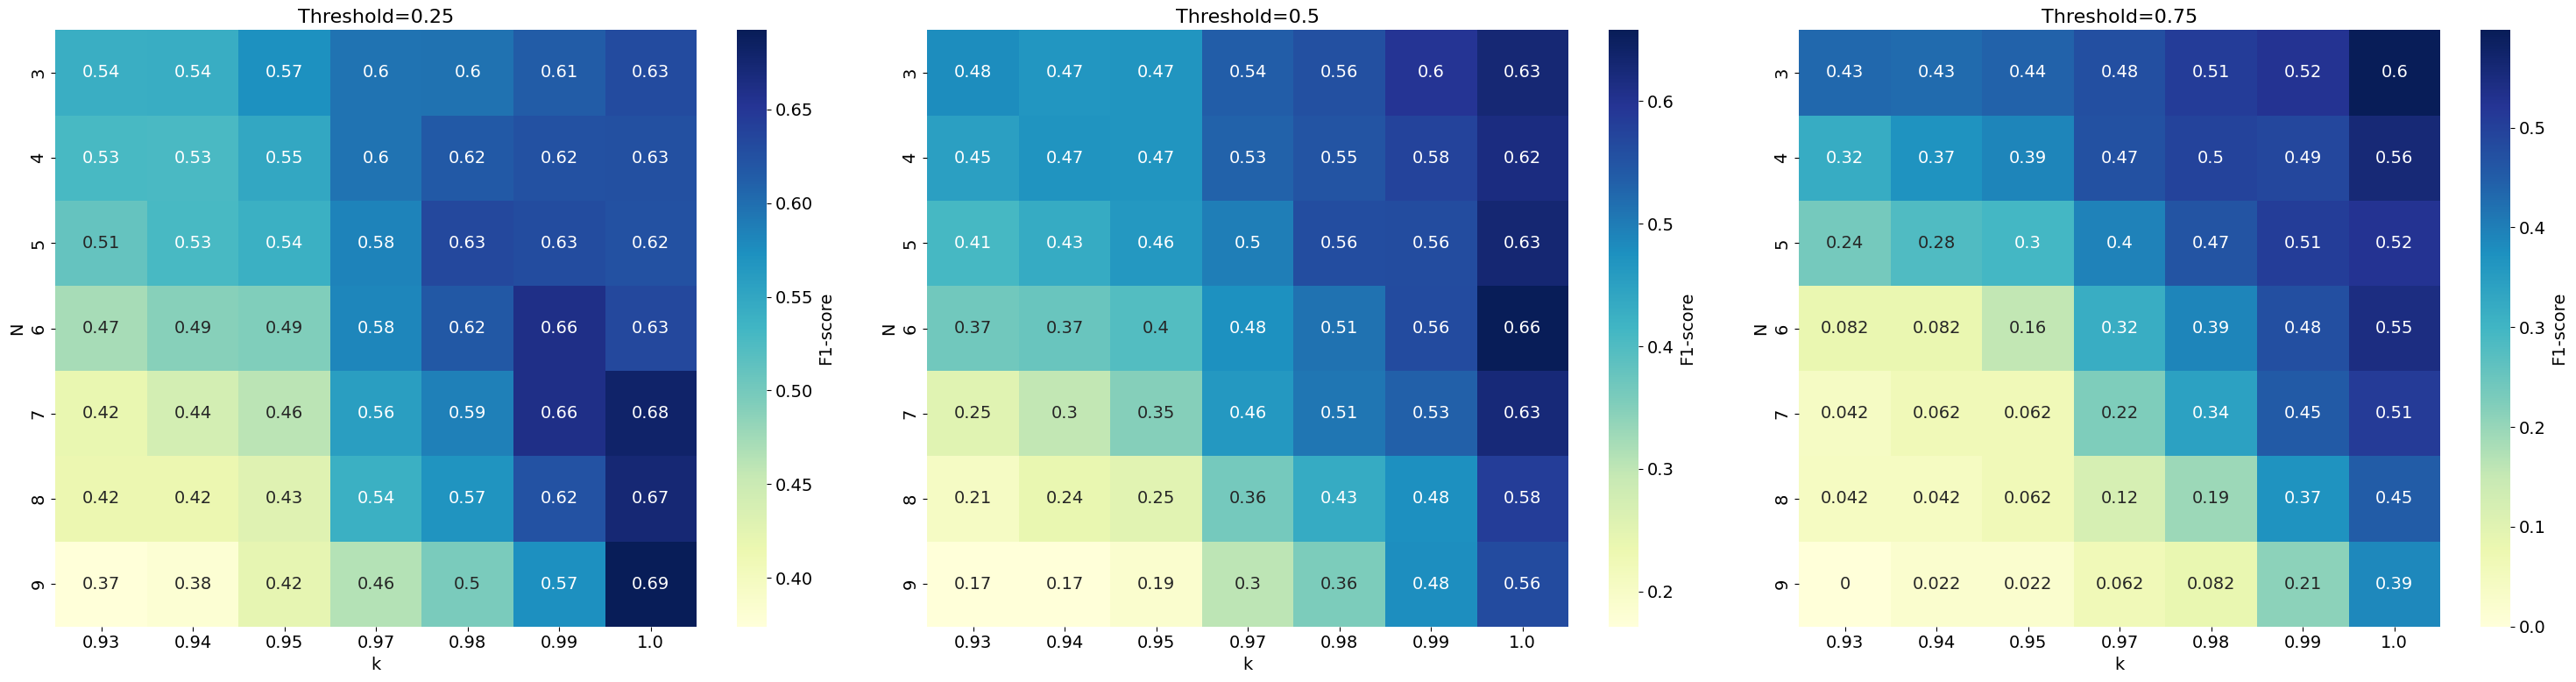

In [ ]:
plt.rcParams['font.size'] = 14

n = len(parameter_study_matrix)

plt.figure(figsize=(n*10, 8))

for idx, (th, nested_data) in enumerate(parameter_study_matrix.items(), start=1):
    df = pd.DataFrame(nested_data).T

    plt.subplot(1, n, idx)
    sns.heatmap(df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'F1-score'})

    plt.title(f"Threshold={th}", fontsize=16)
    plt.xlabel('k', fontsize=14)
    plt.ylabel('N', fontsize=14)

plt.tight_layout()
plt.show()


## Selección óptima de parámetros de las matrices de estudio

In [ ]:
# Best metrics indices

max_global_acc_index = np.argmax(global_acc_scores)
max_global_acc_th_index, max_global_acc_N_index, max_global_acc_k_index = np.unravel_index(max_global_acc_index, (num_voting_thresholds, num_N_values, num_k_values))

max_global_recall_index = np.argmax(global_recall_scores)
max_global_recall_th_index, max_global_recall_N_index, max_global_recall_k_index = np.unravel_index(max_global_recall_index, (num_voting_thresholds, num_N_values, num_k_values))

max_global_precision_index = np.argmax(global_precision_scores)
max_global_precision_th_index, max_global_precision_N_index, max_global_precision_k_index = np.unravel_index(max_global_precision_index, (num_voting_thresholds, num_N_values, num_k_values))

max_global_f1_index = np.argmax(global_f1_scores)
max_global_f1_th_index, max_global_f1_N_index, max_global_f1_k_index = np.unravel_index(max_global_f1_index, (num_voting_thresholds, num_N_values, num_k_values))

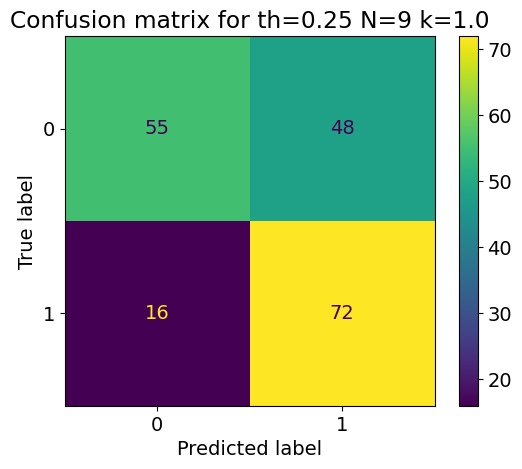

              precision    recall  f1-score   support

         0.0       0.77      0.53      0.63       103
         1.0       0.60      0.82      0.69        88

    accuracy                           0.66       191
   macro avg       0.69      0.68      0.66       191
weighted avg       0.69      0.66      0.66       191



In [ ]:
th = voting_thresholds[max_global_f1_th_index]
N  = N_values[max_global_f1_N_index]
k  = k_values[max_global_f1_k_index]

selected_y_pred = poly_predictions[th][N][k][mask]
selected_y_true = y_true[mask]

cm = confusion_matrix(selected_y_true, selected_y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion matrix for th={th} N={N} k={k}")
plt.show()
print(classification_report(selected_y_true, selected_y_pred))

In [ ]:
labeled_y_true.loc[mask].value_counts()

ORIGdesde  ChangeType  label
NATIVO     drought     0.0      62
           logging     1.0      52
           stable      0.0      41
           fire        1.0      36
dtype: int64

In [ ]:
labeled_y_true.loc[mask].value_counts(normalize=True)

ORIGdesde  ChangeType  label
NATIVO     drought     0.0      0.324607
           logging     1.0      0.272251
           stable      0.0      0.214660
           fire        1.0      0.188482
dtype: float64

In [ ]:
selected_y_pred.name = "pred"
labeled_y_pred = pd.concat((labeled_y_true[mask]["ChangeType"], selected_y_pred), axis=1)

In [ ]:
labeled_y_pred.loc[mask].value_counts(normalize=False)

ChangeType  pred
logging     1.0     43
drought     1.0     39
stable      0.0     32
fire        1.0     29
drought     0.0     23
logging     0.0      9
stable      1.0      9
fire        0.0      7
dtype: int64

In [ ]:
labeled_y_pred.loc[mask].value_counts(normalize=True)

ChangeType  pred
logging     1.0     0.225131
drought     1.0     0.204188
stable      0.0     0.167539
fire        1.0     0.151832
drought     0.0     0.120419
logging     0.0     0.047120
stable      1.0     0.047120
fire        0.0     0.036649
dtype: float64

In [ ]:
17 + 5 + 12 + 20 + 5 + 22 + 4 + 15

100

# Grilla de desempeño y parámetros óptimos

In [ ]:
# Utils

def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

In [ ]:
# Iterated params

N_values = [i for i in range(3, 10)]
k_values = np.around(np.linspace(0.93, 1, 7), 2)
voting_thresholds = [.25, .5, .75]

num_N_values = len(N_values)
num_k_values = len(k_values)
num_voting_thresholds = len(voting_thresholds)

parameter_study_matrix = {th: {N: {} for N in N_values} for th in voting_thresholds}
f1_scores = np.zeros((num_voting_thresholds, num_N_values, num_k_values))
recall_scores = np.zeros((num_voting_thresholds, num_N_values, num_k_values))
precision_scores = np.zeros((num_voting_thresholds, num_N_values, num_k_values))
acc_scores = np.zeros((num_voting_thresholds, num_N_values, num_k_values))

veg_types = ["NATIVO"]
stable_types = ["stable", "drought"]
change_types = ["logging", "fire"]

Confusion matrix for th=0.25 N=9 k=1.0




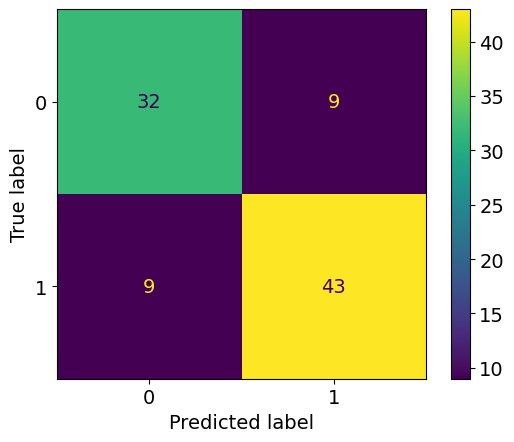



Classification Report for th=0.25 N=9 k=1.0


              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78        41
         1.0       0.83      0.83      0.83        52

    accuracy                           0.81        93
   macro avg       0.80      0.80      0.80        93
weighted avg       0.81      0.81      0.81        93



Confusion matrix for th=0.25 N=9 k=1.0




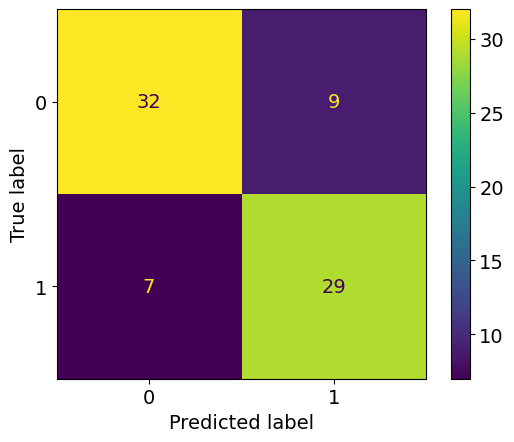



Classification Report for th=0.25 N=9 k=1.0


              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80        41
         1.0       0.76      0.81      0.78        36

    accuracy                           0.79        77
   macro avg       0.79      0.79      0.79        77
weighted avg       0.79      0.79      0.79        77



Confusion matrix for th=0.25 N=9 k=1.0




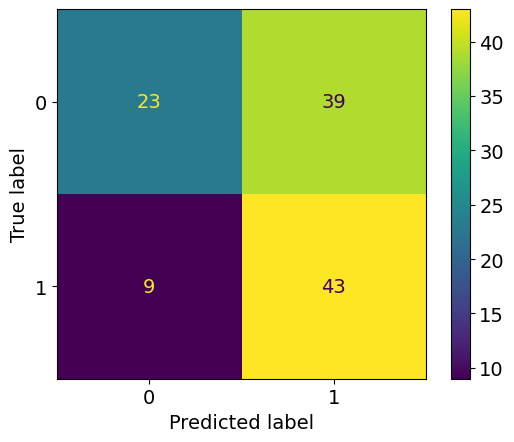



Classification Report for th=0.25 N=9 k=1.0


              precision    recall  f1-score   support

         0.0       0.72      0.37      0.49        62
         1.0       0.52      0.83      0.64        52

    accuracy                           0.58       114
   macro avg       0.62      0.60      0.57       114
weighted avg       0.63      0.58      0.56       114



Confusion matrix for th=0.25 N=9 k=1.0




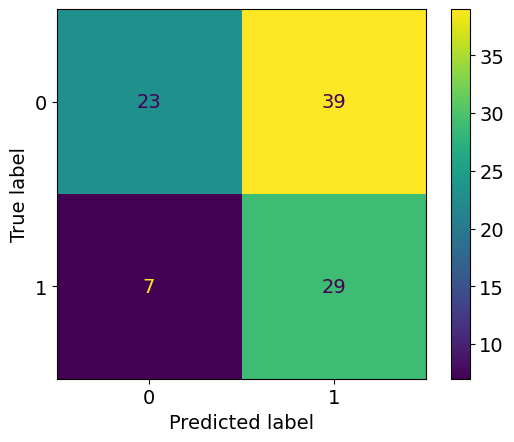



Classification Report for th=0.25 N=9 k=1.0


              precision    recall  f1-score   support

         0.0       0.77      0.37      0.50        62
         1.0       0.43      0.81      0.56        36

    accuracy                           0.53        98
   macro avg       0.60      0.59      0.53        98
weighted avg       0.64      0.53      0.52        98





In [ ]:
metrics_list = []

for veg_type, stable_type, change_type in product(veg_types, stable_types, change_types):

    veg_type_mask = (labeled_y_true["ORIGdesde"] == veg_type)
    stable_type_mask = (labeled_y_true["ChangeType"] == stable_type)
    change_type_mask = (labeled_y_true["ChangeType"] == change_type)

    mask = veg_type_mask & (change_type_mask | stable_type_mask)

    # # Parameter study

    # for index, pair in enumerated_product(voting_thresholds, N_values, k_values):
    #   th, N, k = pair
    #   th_index, N_index, k_index = index
    #   y_pred = poly_predictions[th][N][k]

    #   sel_y_true = y_true[mask]
    #   sel_y_pred = y_pred[mask]

    #   parameter_study_matrix[th][N][k]= f1_score(sel_y_true, sel_y_pred)

    #   f1_scores[th_index][N_index][k_index]  = f1_score(sel_y_true, sel_y_pred)
    #   acc_scores[th_index][N_index][k_index] = accuracy_score(sel_y_true, sel_y_pred)
    #   recall_scores[th_index][N_index][k_index]  = recall_score(sel_y_true, sel_y_pred)
    #   precision_scores[th_index][N_index][k_index]  = precision_score(sel_y_true, sel_y_pred, zero_division=0)

    # plt.rcParams['font.size'] = 14

    # n = len(parameter_study_matrix)

    # plt.figure(figsize=(n * 10, 8))

    # print(f"Vegetation type: {veg_type}")
    # print(f"Non-change type: {stable_type}")
    # print(f"Change type: {change_type}")
    # print("\n")

    # print("F1-score for all parameters configurations")
    # print("\n")


    # for idx, (th, nested_data) in enumerate(parameter_study_matrix.items(), start=1):
    #     df = pd.DataFrame(nested_data).T

    #     plt.subplot(1, n, idx)
    #     sns.heatmap(df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'F1-score'})

    #     plt.title(f"Threshold={th}", fontsize=16)
    #     plt.xlabel('k', fontsize=14)
    #     plt.ylabel('N', fontsize=14)

    # plt.tight_layout()
    # plt.show()
    # print("\n")

    # # Optimal model
    # max_f1_index = np.argmax(f1_scores)
    # max_f1_th_index, max_f1_N_index, max_f1_k_index = np.unravel_index(max_f1_index, (num_voting_thresholds, num_N_values, num_k_values))

    # max_acc_index = np.argmax(acc_scores)
    # max_acc_th_index, max_acc_N_index, max_acc_k_index = np.unravel_index(max_acc_index, (num_voting_thresholds, num_N_values, num_k_values))

    # max_recall_index = np.argmax(recall_scores)
    # max_recall_th_index, max_recall_N_index, max_recall_k_index = np.unravel_index(max_recall_index, (num_voting_thresholds, num_N_values, num_k_values))

    # max_precision_index = np.argmax(precision_scores)
    # max_precision_th_index, max_precision_N_index, max_precision_k_index = np.unravel_index(max_precision_index, (num_voting_thresholds, num_N_values, num_k_values))

    th = voting_thresholds[max_global_f1_th_index]
    N = N_values[max_global_f1_N_index]
    k = k_values[max_global_f1_k_index]

    selected_y_pred = poly_predictions[th][N][k][mask]
    selected_y_true = y_true[mask]
    cm = confusion_matrix(selected_y_true, selected_y_pred)

    print(f"Confusion matrix for th={th} N={N} k={k}")
    print("\n")
    ConfusionMatrixDisplay(cm).plot()
    plt.show()
    print("\n")

    print(f"Classification Report for th={th} N={N} k={k}")
    print("\n")
    print(classification_report(selected_y_true, selected_y_pred, zero_division=0))

    metrics = {
        'Vegetation Type': veg_type,
        'Non-Change Type': stable_type,
        'Change Type': change_type,
        'Accuracy': accuracy_score(selected_y_true, selected_y_pred),
        'F1-Score': f1_score(selected_y_true, selected_y_pred),
        'Recall': recall_score(selected_y_true, selected_y_pred),
        'Precision': precision_score(selected_y_true, selected_y_pred),
    }

    metrics_list.append(metrics)

    print("\n" + "="*200 + "\n")



In [ ]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df

,Vegetation Type,Non-Change Type,Change Type,Accuracy,F1-Score,Recall,Precision
0,NATIVO,stable,logging,0.806452,0.826923,0.826923,0.826923
1,NATIVO,stable,fire,0.792208,0.783784,0.805556,0.763158
2,NATIVO,drought,logging,0.578947,0.641791,0.826923,0.524390
3,NATIVO,drought,fire,0.530612,0.557692,0.805556,0.426471
